In [1]:
import pyxdf
import matplotlib.pyplot as plt
import numpy as np
import math

from scipy import signal
from scipy import linalg

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

dr = '../Recordings/Speller/'
file_1 = 'run_03.xdf'
file_2 = 'run_04.xdf'

# file 'run_03' contains data for spelling 'QUICK'
# file 'run_04' contains data for spelling 'P3EEG'

In [2]:
def speller_file_to_dict(data):
    run = {
        'data': [],
        'time_stamps': [],
        'aux': [],
        'aux_time_stamps': [],
        'markers': [],
        'marker_time_stamps': [],
        'sample_rate': {},
    }
    for stream in data:
        if stream['info']['name'][0] == 'eeg_data':
            run['data'] = stream['time_series']
            run['time_stamps'] = stream['time_stamps']
            run['sample_rate']['eeg'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'aux_data':
            run['aux'] = stream['time_series']
            run['aux_time_stamps'] = stream['time_stamps']
            run['sample_rate']['aux'] = float(stream['info']['nominal_srate'][0])
        elif stream['info']['name'][0] == 'P300_Speller_Markers':
            run['markers'] = stream['time_series']
            run['marker_time_stamps'] = stream['time_stamps']
        else:
            print('Warning unmatched stream name')
            
    return run

data = {
    'run': [],
}

for file_nm in [file_1, file_2]:
    imported_data, _ = pyxdf.load_xdf(dr+file_nm)
    run = speller_file_to_dict(imported_data)
    data['run'].append(run)
    
# print(data)

In [3]:
def plot_time_series(X, Y, labels, xlabel=None, ylabel=None, title=None, fig=None, ax=None):
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

    for i in range(len(Y.T)):
        y = Y[:,i]
        ax.plot(X, y, label=labels[i])
        
    xlabel = xlabel if xlabel is not None else 'Time'
    ylabel = ylabel if ylabel is not None else 'Amplitude'
    title = title if title is not None else 'Time Series'
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True)
    _ = ax.legend(loc='upper left')
    
    return fig, ax

def plot_epochs(ch_epochs, xlabel='Times (ms)', ylabel='Epochs', title='Epoch Comparison', tmin=None, tmax=None):
    fig, ax = plt.subplots(figsize = (10, 3), dpi = 90)

    if tmin == None or tmax == None:
        tmin = 0
        tmax = ch_epochs.shape[-1]
    extent = [tmin, tmax, 0, len(ch_epochs)]
    
    plot = ax.matshow(ch_epochs, interpolation='nearest', origin='lower', aspect='auto', extent=extent)

    ax.xaxis.set_ticks_position("bottom")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.axis('auto')
    ax.axis('tight')
    ax.axvline(0, color='k', linewidth=1, linestyle='--')

    cbar = fig.colorbar(plot)
    cbar.ax.set_ylabel(r'Amplitude ($\mu$V)', rotation=270, labelpad=12)
    
    return fig, ax

def add_markers_to_plot(markers, time_stamps, fig, ax):
    for timestamp, marker in zip(time_stamps, markers):
#             if (marker[0] == '1'):
            if '[' in marker[0]:
                ax.axvline(x=timestamp, color='C1')

In [4]:
# =====================
# Re Reference all data
# =====================
def re_reference(session_data, new_ref_ch_idx):
    # returns data with the new reference channel removed... because its zeros
    new_ref = session_data[:,new_ref_ch_idx]
    re_referenced = session_data - new_ref[:,None]
    re_referenced = np.delete(re_referenced, new_ref_ch_idx, axis=1)
    
    return re_referenced

# =====================
# Epochs and windowing
# =====================
def ms_to_samples(duration, rate=250):
    return int((duration/1000.0) * rate)


def get_epoch(data, data_times, stim_time, pre_stim_ms, post_stim_ms, sample_rate):
    # great for grabbing around a stimulus event time.
    
    # TODO: is there a faster way?
    i = (np.abs(data_times - stim_time)).argmin()
    start = i - ms_to_samples(pre_stim_ms, sample_rate)
    stop = i + ms_to_samples(post_stim_ms, sample_rate) + 1
    epoch = data[start:stop]
    
    return epoch


# ==========
# Epoch Prep
# ==========
def dc_offset(epoch_data, sample_rate):
    # epoch_data should be 2D, (samples, channels)
    offset = np.mean(epoch_data, 0)

    return epoch_data - offset


def filter_eeg(epoch_data, sample_rate, f_range):
    # epoch_data should be 2D, (samples, channels)
    nyq = 0.5 * sample_rate
    low_limit = f_range[0] / nyq
    high_limit = f_range[1] / nyq
    
    sos = signal.butter(2, [low_limit, high_limit], btype='bandpass', output='sos')
    sig_filt = signal.sosfiltfilt(sos, epoch_data, axis=0)    
    
    return np.array(sig_filt)

def baseline_center(epoch_data, baseline_duration_ms, sample_rate):
    # epoch_data should be 2D, (samples, channels)
    baseline_samples = ms_to_samples(baseline_duration_ms, sample_rate)
    pre_stimulus = epoch_data[:baseline_samples]
    baseline = np.mean(pre_stimulus, 0)
    
    return epoch_data - baseline


def prepare_epochs(epochs, sample_rate, baseline_duration=100):
    # epochs should be 3D, (event, samples, channels)
    # baseline duration, in ms
    
    prepped = []
    for epoch in epochs:
        temp_data = dc_offset(epoch, sample_rate)
#         temp_data = baseline_center(temp_data, baseline_duration, sample_rate)
        prepped.append(temp_data)
        
    return np.array(prepped)

# ================
# Speller Specific
# ================
ltr_key = ['ABCDEF',
           'GHIJKL',
           'MNOPQR',
           'STUVWX',
           'YZ1234',
           '56789_']

# answer_key = {
#     'Q': [3, 11],2,10
#     'U': [4, 9],3,8
#     'I': [2, 9],
#     'C': [1, 9],
#     'K': [2, 11],
#     'P': [3, 10],
#     '3': [5, 11],
#     'E': [1, 11],
#     'G': [2, 7],    
# }
answer_key = {}
for i, row in enumerate(ltr_key):
    for j, ch in enumerate(row):
        answer_key[ch] = [i,j+6]
        
print(answer_key)

{'A': [0, 6], 'B': [0, 7], 'C': [0, 8], 'D': [0, 9], 'E': [0, 10], 'F': [0, 11], 'G': [1, 6], 'H': [1, 7], 'I': [1, 8], 'J': [1, 9], 'K': [1, 10], 'L': [1, 11], 'M': [2, 6], 'N': [2, 7], 'O': [2, 8], 'P': [2, 9], 'Q': [2, 10], 'R': [2, 11], 'S': [3, 6], 'T': [3, 7], 'U': [3, 8], 'V': [3, 9], 'W': [3, 10], 'X': [3, 11], 'Y': [4, 6], 'Z': [4, 7], '1': [4, 8], '2': [4, 9], '3': [4, 10], '4': [4, 11], '5': [5, 6], '6': [5, 7], '7': [5, 8], '8': [5, 9], '9': [5, 10], '_': [5, 11]}


In [5]:
# Use mastoid as ref, then avg-ref the second mastoid
# Place the ground at AFz
channels = ['ref', 'FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']
aux_chs = ['aux ch_1', 'aux ch_2', 'aux ch_3']

# assigning data... a bit redundant but the hope is to help make the pipelining easier
run_1 = data['run'][0]
run_2 = data['run'][1]

r1_eeg = run_1['data']
r1_eeg_ts = run_1['time_stamps']
r1_aux = run_1['aux']
r1_aux_ts = run_1['aux_time_stamps']
r1_markers = run_1['markers']
r1_markers_ts = run_1['marker_time_stamps']

r2_eeg = run_2['data']
r2_eeg_ts = run_2['time_stamps']
r2_aux = run_2['aux']
r2_aux_ts = run_2['aux_time_stamps']
r2_markers = run_2['markers']
r2_markers_ts = run_2['marker_time_stamps']

new_ref_ch_idx = 0
r1_eeg = re_reference(r1_eeg, new_ref_ch_idx)
r2_eeg = re_reference(r2_eeg, new_ref_ch_idx)
del channels[new_ref_ch_idx]

r1_eeg = filter_eeg(r1_eeg, 250, [1.,20.] )
r2_eeg = filter_eeg(r2_eeg, 250, [1.,20.] )

# remove Fp1 channel
# r1_eeg = np.delete(r1_eeg, -1, axis=1)
# r2_eeg = np.delete(r2_eeg, -1, axis=1)
# del channels[-1]

# convert times to int milliseconds
r1_eeg_ts = (r1_eeg_ts*1000).astype(int)
r2_eeg_ts = (r2_eeg_ts*1000).astype(int)
r1_aux_ts = (r1_aux_ts*1000).astype(int)
r2_aux_ts = (r2_aux_ts*1000).astype(int)
r1_markers_ts = (r1_markers_ts*1000).astype(int)
r2_markers_ts = (r2_markers_ts*1000).astype(int)

print(channels)
pz = channels.index('Pz')
fp1 = channels.index('Fp1')

['FCz', 'Fz', 'Cz', 'Pz', 'Oz', 'CPz', 'Fp1']


In [6]:
# HANDLE PHOTOSENSORS
# -------------------
# scaling for dim display
# clean and prep aux channel 0010010
# get associated markers and time stamps
# get trials of markers and time stamps

def get_ts_for_on_rise_threshold(data, data_ts, threshold):
    thr = (data > threshold) + 0
    rise = thr[1:] > thr[:-1]
    rise = np.insert(rise, 0, False) # accounts for lost position above
    return data_ts[rise]

def divide_markers(markers):
    # rc = row and column
    marker_collection = []
    target_collection = []
    y_collection = []
    for marker_arr in markers:
        marker = marker_arr[0]
        if '[' in marker:
            lbl = marker.split('[')[1].split(']')[0]
            target_collection.append(lbl)
            marker_collection.append([])
            y_collection.append([])
        elif marker.isnumeric():
            marker = int(marker)
            marker_collection[-1].append(marker)
            key = answer_key[target_collection[-1]]
            if marker in key:
                y_collection[-1].append(1)
            else:
                y_collection[-1].append(0)
                
    
    return target_collection, np.array(marker_collection), np.array(y_collection)

def sync_sensor_to_markers(sensor_ts, stim_markers, targets):
    len_a = len(sensor_ts.flatten())
    len_b = len(stim_markers.flatten())
    len_c = len(targets.flatten())
    assert len_a == len_b == len_c, 'Invalid Operation' # dimensions must match
    
    synced = np.vstack((sensor_ts.flatten(),
                        stim_markers.flatten(),
                        targets.flatten()))
    return synced.T

# scaling
max_run1 = max(r1_aux[:,1])
max_run2 = max(r2_aux[:,1])
scaler = max_run2/max_run1
r1_aux[:,1] = r1_aux[:,1] * scaler


PHOTO_SENSOR_THRESHOLD = 70 # this is based on a visual plot.
r1_photosensor_onsets = get_ts_for_on_rise_threshold(r1_aux[:,1], r1_aux_ts, PHOTO_SENSOR_THRESHOLD)
r2_photosensor_onsets = get_ts_for_on_rise_threshold(r2_aux[:,1], r2_aux_ts, PHOTO_SENSOR_THRESHOLD)

# TODO: automate this!
# There are 2 test sensor blinks that we can get rid of and there is a
# graphical blink at the very beginning of run 2 that needs to be removed.
r1_photosensor_onsets = r1_photosensor_onsets[2:]
r2_photosensor_onsets = r2_photosensor_onsets[3:]

r1_target_ltr, r1_stim_markers, r1_y = divide_markers(r1_markers)
r2_target_ltr, r2_stim_markers, r2_y = divide_markers(r2_markers)

r1_events = sync_sensor_to_markers(r1_photosensor_onsets, r1_stim_markers, r1_y)
r2_events = sync_sensor_to_markers(r2_photosensor_onsets, r2_stim_markers, r2_y)

print(r1_events[:5])
print(r1_events.shape)

[[1437429       5       0]
 [1437713       9       0]
 [1437997      10       1]
 [1438281       8       0]
 [1438565       1       0]]
(600, 3)


In [7]:
# TRUNCATE and NORMALIZE
def get_session_mask(eeg_ts, markers_ts, events):
    first_photosensor_time = events[0,0]
    first_marker_time = markers_ts[1] # skip the first...its too early and not useful
    last_photosensor_time = events[-1,0]
    last_marker_time = markers_ts[-1]
    session_win_start = min(first_photosensor_time, first_marker_time) - 1000
    session_win_stop = max(last_photosensor_time, last_marker_time) + 1000
    print(f'session: {session_win_start} to {session_win_stop}')
    mask = (eeg_ts >= session_win_start) & (eeg_ts <= session_win_stop)
    return mask
    
r1_mask = get_session_mask(r1_eeg_ts, r1_markers_ts, r1_events)
r2_mask = get_session_mask(r2_eeg_ts, r2_markers_ts, r2_events)

r1_eeg = r1_eeg[r1_mask]
r2_eeg = r2_eeg[r2_mask]
r1_eeg_ts = r1_eeg_ts[r1_mask]
r2_eeg_ts = r2_eeg_ts[r2_mask]

# normalize
def zero_and_normalize(eeg_data):
    eeg_data = eeg_data - np.mean(eeg_data, 0)
    eeg_data = eeg_data / np.std(eeg_data, 0)
    return eeg_data

r1_eeg = zero_and_normalize(r1_eeg)
r2_eeg = zero_and_normalize(r2_eeg)

session: 1429349 to 1657677
session: 2408504 to 2636872


In [8]:
# Epoch durations in ms
PRE_STIM = 100
POST_STIM = 800

SAMPLE_RATE = 250.0 # Hz

# Make Epochs
r1_epochs = []
for time in r1_photosensor_onsets:
    # get epoch based on time stamp
    epoch = get_epoch(r1_eeg, r1_eeg_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
    r1_epochs.append(epoch)
    
r2_epochs = []
for time in r2_photosensor_onsets:
    # get epoch based on time stamp
    epoch = get_epoch(r2_eeg, r2_eeg_ts, time, PRE_STIM, POST_STIM, SAMPLE_RATE)
    r2_epochs.append(epoch)
    

# Prep Epochs
r1_epochs = prepare_epochs(r1_epochs, SAMPLE_RATE)
r2_epochs = prepare_epochs(r2_epochs, SAMPLE_RATE)
r1_epochs_ts = r1_photosensor_onsets
r2_epochs_ts = r2_photosensor_onsets

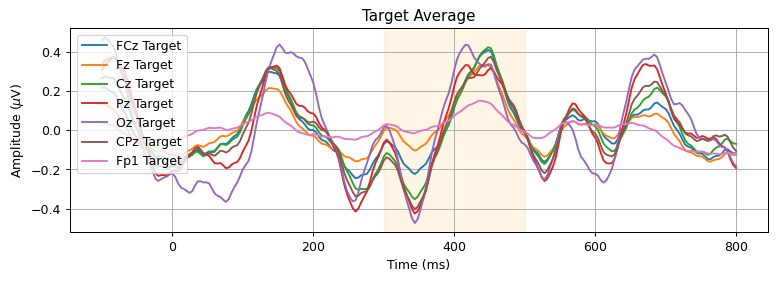

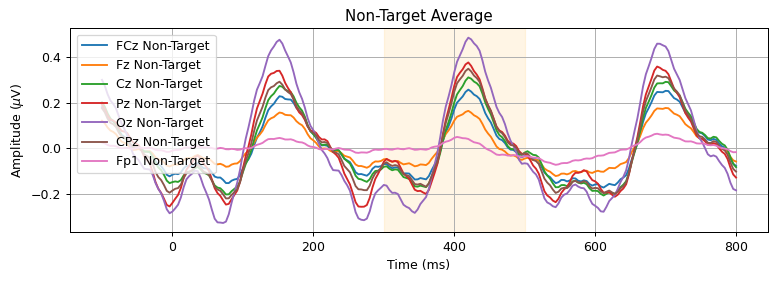

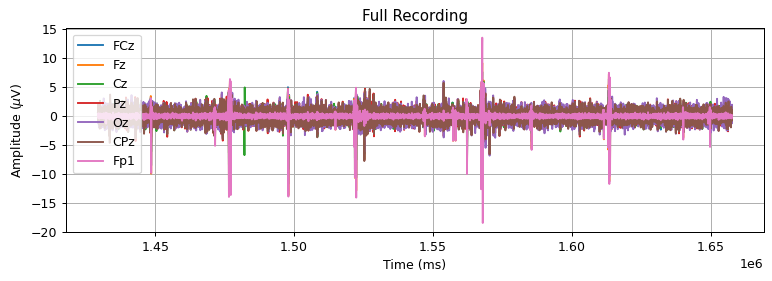

In [9]:
y = r1_events[:,2]
target_epochs = r1_epochs[y == 1]
non_target_epochs = r1_epochs[y == 0]

x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(r2_epochs.shape[1])]

target_epoch_avg = np.mean(target_epochs, axis=0)
non_target_epoch_avg = np.mean(non_target_epochs, axis=0)

g_labels = [ch + ' Target' for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    target_epoch_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Target Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = [ch + ' Non-Target' for ch in channels]
fig, ax = plot_time_series(
    x_for_plot,
    non_target_epoch_avg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Non-Target Average'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = channels
fig, ax = plot_time_series(
    r1_eeg_ts,
    r1_eeg,
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Full Recording'
)
# _ = ax.axvspan(300, 500, color='orange', alpha=0.1)

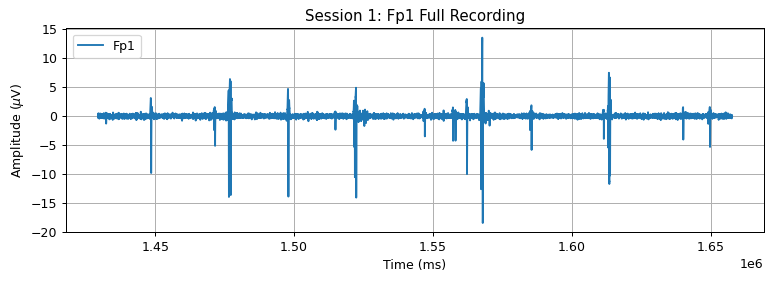

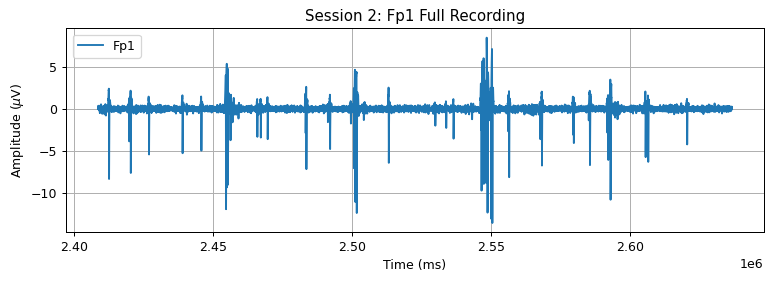

In [10]:
g_labels = ['Fp1']
fig, ax = plot_time_series(
    r1_eeg_ts,
    r1_eeg[:,fp1, None], # None == np.newaxis, adds axis
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Session 1: Fp1 Full Recording'
)

g_labels = ['Fp1']
fig, ax = plot_time_series(
    r2_eeg_ts,
    r2_eeg[:,fp1, None], # None == np.newaxis, adds axis
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Session 2: Fp1 Full Recording'
)

In [11]:
def get_blinks(data, data_ts, ch, blink_dev_thresh=2.0):
    ch_data = data[:,ch]
    ch_mean = ch_data.mean()
    ch_std = ch_data.std()
    ch_dev = np.abs((ch_data - ch_mean) / ch_std)
    blink_mask = ch_dev > blink_dev_thresh
    blink_int = blink_mask.astype(int)
    blinks = []
    for i, val in enumerate(blink_int):
        if i == 0:
            continue

        prev = blink_int[i-1]
        if val != prev:
            if val == 1:
                blinks.append([data_ts[i]])
            else:
                blinks[-1].append(data_ts[i])
                
    return np.array(blinks), blink_mask

r1_blinks, _ = get_blinks(r1_eeg, r1_eeg_ts, fp1, 1.5)
r2_blinks, _ = get_blinks(r2_eeg, r2_eeg_ts, fp1, 1.5)

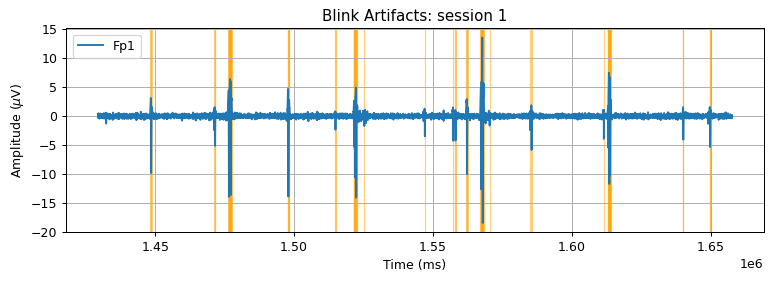

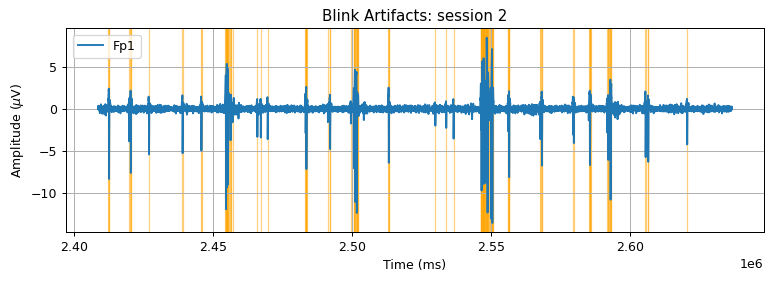

In [12]:
g_labels = ['Fp1']
fig, ax = plot_time_series(
    r1_eeg_ts,
    r1_eeg[:,fp1, None], # None == np.newaxis, adds axis
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Blink Artifacts: session 1'
)
for blink in r1_blinks:
    _ = ax.axvspan(blink[0], blink[1], color='orange', alpha=0.5)
    
g_labels = ['Fp1']
fig, ax = plot_time_series(
    r2_eeg_ts,
    r2_eeg[:,fp1, None], # None == np.newaxis, adds axis
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Blink Artifacts: session 2'
)
for blink in r2_blinks:
    _ = ax.axvspan(blink[0], blink[1], color='orange', alpha=0.5)

In [13]:
def get_bad_epochs_indices(epochs_ts, blinks):    
    count = 0
    bad_epoch_i = []
    for i, time in enumerate(epochs_ts):
        e_start = time - PRE_STIM
        e_stop = time + POST_STIM
        a = (blinks[:,0] >= e_start) & (blinks[:,0] < e_stop)
        overlap = np.count_nonzero(a)
        if overlap == 0:
            b = (blinks[:,1] > e_start) & (blinks[:,1] <= e_stop)
            overlap = np.count_nonzero(b)

        if overlap > 0:
            bad_epoch_i.append(i)
            count += 1
            
    print(f'{count} contaminated epochs!')
    return np.array(bad_epoch_i)

r1_bad_epochs = get_bad_epochs_indices(r1_epochs_ts, r1_blinks)
print(r1_bad_epochs)
print(r1_events[r1_bad_epochs, 2])

r2_bad_epochs = get_bad_epochs_indices(r2_epochs_ts, r2_blinks)
print(r2_bad_epochs)
print(r2_events[r2_bad_epochs, 2])

38 contaminated epochs!
[ 33  34  35  36 107 108 109 165 166 167 168 220 221 222 298 299 330 331
 332 333 334 335 345 346 347 348 393 394 395 396 478 479 542 543 544 545
 574 575]
[0 1 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0
 0]
67 contaminated epochs!
[  9  10  11  12  31  32  33  34  70  71  92  93  94 131 133 134 135 136
 143 185 186 187 188 189 212 213 214 215 238 239 255 256 257 258 310 311
 322 323 330 331 332 333 367 368 369 370 371 405 406 407 408 443 444 461
 462 463 464 465 499 500 501 502 503 504 548 549 550]
[0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0]


299 330


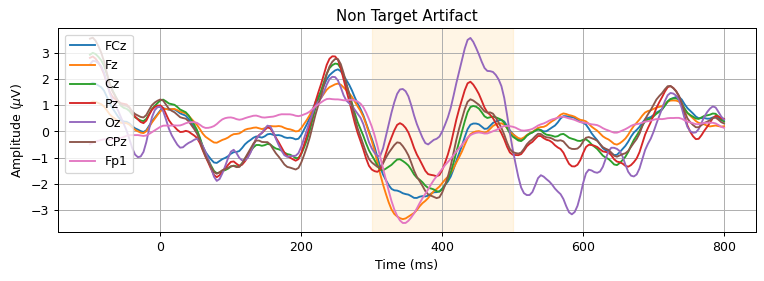

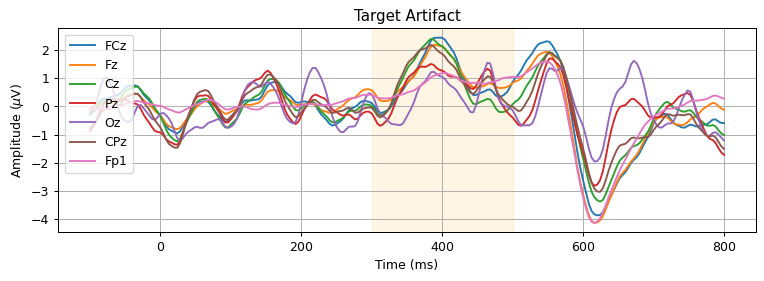

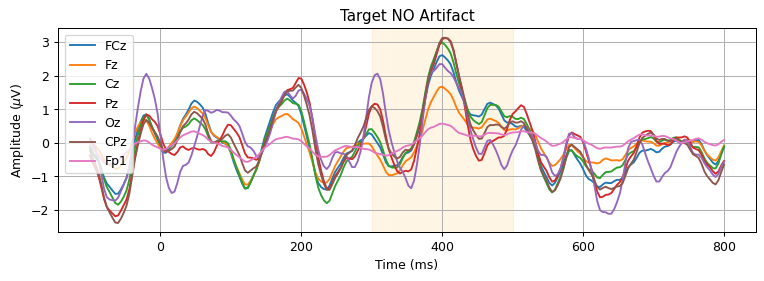

In [14]:
b_nontarget = r1_bad_epochs[15]
b_target = r1_bad_epochs[16]
print(b_nontarget, b_target)
g_target = 19

x_for_plot = [(i*(1000/SAMPLE_RATE))-PRE_STIM for i in range(r2_epochs.shape[1])]

g_labels = channels
fig, ax = plot_time_series(
    x_for_plot,
    r1_epochs[b_nontarget],
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Non Target Artifact'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = channels
fig, ax = plot_time_series(
    x_for_plot,
    r1_epochs[b_target],
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Target Artifact'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

g_labels = channels
fig, ax = plot_time_series(
    x_for_plot,
    r1_epochs[g_target],
    labels = g_labels,
    xlabel='Time (ms)',
    ylabel=r'Amplitude ($\mu$V)',
    title=f'Target NO Artifact'
)
_ = ax.axvspan(300, 500, color='orange', alpha=0.1)

In [15]:
def window_and_combine_features(epochs, sub_samples_per_ch, time_window):
    # epochs is expected to be 3D, (epoch, sample, channel)
    
    t_start = ms_to_samples(time_window[0], 250)
    t_len = ms_to_samples(time_window[1] - time_window[0], 250)
    
    window_len = np.round(t_len/sub_samples_per_ch).astype(int)
    windowed = np.zeros(( len(epochs), epochs.shape[-1], sub_samples_per_ch))
    
    for i in range(sub_samples_per_ch):
        win_start = i * window_len + t_start
        win_stop = win_start + window_len
        win_avg = np.mean(epochs[:,win_start:win_stop,:], axis=1) # (epochs x ch)
        windowed[:,:,i] = win_avg

    windowed = windowed.reshape((len(epochs), epochs.shape[-1] * sub_samples_per_ch))

    return windowed

def balance_zeros(data, y):
    # truncates the zeros down to the same size as ones.
    # assumes more zeros than ones
    zeros = np.sum(y == 0)
    ones = np.sum(y == 1)
    step = int(zeros/ones)
    print(f'{100*zeros/y.shape[0]:.2f}% zeros')
    sort_order = np.argsort(y, kind='stable')
    half_zeros = [i for i in range(0,zeros,step)]
    sort_order = np.concatenate((sort_order[half_zeros], sort_order[-ones:]), axis=0)
    orig_order = np.sort(sort_order)
    y_part = y[orig_order]
    data_part = data[orig_order]
    
    return data_part, y_part


r1_ep_mask = np.ones(len(r1_epochs), np.bool)
r1_ep_mask[r1_bad_epochs] = 0

r1_epochs_clean = r1_epochs[r1_ep_mask]
r1_y_clean = r1_y.flatten()[r1_ep_mask]
r1_events_clean = r1_events[r1_ep_mask]

r2_ep_mask = np.ones(len(r2_epochs), np.bool)
r2_ep_mask[r2_bad_epochs] = 0

r2_epochs_clean = r2_epochs[r2_ep_mask]
r2_y_clean = r2_y.flatten()[r2_ep_mask]
r2_events_clean = r2_events[r2_ep_mask]

In [30]:
# session 1
X, y = balance_zeros(r1_epochs_clean[:,:,[0,1,2,3,5]], r1_y_clean) # remove fp1
print(X.shape)
X_windowed = window_and_combine_features(X, 7, (200, 600))
print(X_windowed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y, test_size=0.20, random_state=50)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))

83.99% zeros
(185, 226, 5)
(185, 35)
Simple 20% test split accuracy: 0.5405405405405406


In [17]:
# session 2
X, y = balance_zeros(r2_epochs_clean[:,:,[0,1,2,3,5]], r2_y_clean) # remove fp1
print(X.shape)
X_windowed = window_and_combine_features(X, 7, (200, 600))
print(X_windowed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y, test_size=0.20, random_state=40)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))

84.62% zeros
(173, 226, 5)
(173, 35)
Simple 20% test split accuracy: 0.6571428571428571


In [18]:
def test_LDA_prediction(target_ltrs, stim_labels, epochs, y, picks):
    for i, target_ltr in enumerate(target_ltrs):
        test_epoch = epochs[i][picks[i]]
        test_stim_labels = stim_labels[i][picks[i]]
        test_y = y[i][picks[i]]
        train_epochs = np.delete(epochs, i, 0)
        train_picks = np.delete(picks, i, 0)
        train_epochs = train_epochs[train_picks]
        train_stim_labels = np.delete(stim_labels, i, 0)
        train_stim_labels = train_stim_labels[train_picks]
        train_y = np.delete(y, i, 0)
        train_y = train_y[train_picks]
        
        shp = train_epochs.shape

        print('training shape:', shp)
        train_x = train_epochs
        
        train_x, train_y = balance_zeros(train_x, train_y)
        LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
        LDA_clf = LDA_clf.fit(train_x, train_y)
        print(f'classifier score: {LDA_clf.score(test_epoch, test_y)}')
        
        confidence = LDA_clf.predict_proba(test_epoch)

        conf_avg = []
        for j in range(len(ltr_key)*2):
            avg = np.mean(confidence[test_stim_labels == j, 1])
            conf_avg.append(avg)
            
#         print(conf_avg)
            
        conf_avg_rows = conf_avg[:len(ltr_key)]
        conf_avg_cols = conf_avg[len(ltr_key):]
        
        max_row = np.argmax(conf_avg_rows)
        max_col = np.argmax(conf_avg_cols)
        print(f'-- Run: {i}, Results --')
        print(f'row choice: {max_row}, column choice: {max_col}')
        result = ltr_key[max_row][max_col]
#         print(result == target_ltr)
        print(result, target_ltr)
    
shp = r1_y.shape
r1_bad_epochs_live = np.vstack((r1_bad_epochs//shp[1], r1_bad_epochs%shp[1])).T
r1_picks = np.ones(shp, bool)
r1_picks[r1_bad_epochs_live[:,0],r1_bad_epochs_live[:,1]] = 0

# remove fp1
r1_windowed = window_and_combine_features(r1_epochs[:,:,[0,1,2,3,5]], 7, (200, 600))
print(r1_windowed.shape)

epochs_by_target = r1_windowed.reshape(r1_y.shape + r1_windowed.shape[1:])
test_LDA_prediction(r1_target_ltr,
                    r1_stim_markers,
                    epochs_by_target,
                    r1_y,
                    r1_picks)

# epoched_index = np.arange(0,shp[0]*shp[1]).reshape(shp)

(600, 35)
training shape: (449, 35)
83.74% zeros
classifier score: 0.5486725663716814
-- Run: 0, Results --
row choice: 0, column choice: 3
D Q
training shape: (449, 35)
83.96% zeros
classifier score: 0.5575221238938053
-- Run: 1, Results --
row choice: 5, column choice: 3
8 U
training shape: (454, 35)
83.92% zeros
classifier score: 0.6111111111111112
-- Run: 2, Results --
row choice: 3, column choice: 2
U I
training shape: (448, 35)
84.15% zeros
classifier score: 0.5526315789473685
-- Run: 3, Results --
row choice: 1, column choice: 1
H C
training shape: (448, 35)
84.15% zeros
classifier score: 0.6666666666666666
-- Run: 4, Results --
row choice: 0, column choice: 4
E K


---
---
# xDAWN
---

$X=DA+N$

$X \in \mathbb{R}^{N_txN_s}$ matrix of recorded EEG signals.

$N_s$ = number of sensors

$N_t$ = number of temporal samples

$A\in \mathbb{R}^{N_exN_s}$ matrix of ERP signals.

$N_e$ = number of samples corresponding to the ERP ~600 milliseconds

$D\in \mathbb{R}^{N_txN_e}$ Toeplitz $T_k$ is the stimulus onset of the $k^{th}$ target stimulus

$N$ is the ongoing activity of the user's brain including artifacts

### least square estimation of A
$\hat{A}=\underset{A}{\mathrm{argmin}}{\lVert X-DA \rVert}_2^2$

$\hat{A}=(D^T D)^{-1} D^T X$

With classical epoching of $X$ to estimate $A$ leads to<br />
$A^{*} = D^T X$

### second idea
$XU=DAU+NU$

$U \in \mathbb{R}^{N_sxN_f}$

$N_f$ = spatial filters $\mathbf{u}_i$, the $i^{th}$ column of $U$ $(1\leq i \leq N_f \leq N_s)$

$\hat{A}=\Sigma \Delta \Pi^T$

$\Delta$ = nonnegative diagonal elements in decreasing order.<br />
signal and noise subspaces

$\Sigma = \begin{bmatrix} \Sigma_s & \Sigma_n \end{bmatrix}$

$\Delta = \begin{bmatrix} \Delta_s & 0 \\ 0 & \Delta_n \end{bmatrix}$

$\Pi = \begin{bmatrix} \Pi_s & \Pi_n \end{bmatrix}$

$U_{pca} = \Pi_s$

$\hat{A} = \Sigma_s \Delta_s \Pi_s^T + \Sigma_n \Delta_n \Pi_n^T$

$X = D A_{pca}^{'} W_{pca}^{T} + N^{'}$

$A_{pca}^{'} = \Sigma_s \Delta_s$ and $W_{pca}=\Pi_s$ iis the spatial distribution over sensors

$N'=N+D \Sigma_n \Delta_n \Pi_n^T$

>  Even if the PCA enhances the evoked potentials, the major drawback of this solution is that the noise N is not directly taken into account to estimate the spatial filters. Indeed, filtered signals are then obtained by

> $ \begin{aligned} \hat{S}_{pca} &= XU_{pca} \\ &= DA'_{pca} + N'U_{pca} \end{aligned}$

> where noisy term $N′ U_{pca} = N U_{pca}$ (since $\Pi_n$ and $\Pi_s$ are orthogonal) could also be largely amplified compared to noisy term $N$

#### overcoming the problem
use spatial filter $U$

$\hat{U} = \mathrm{arg}\underset{U}{\mathrm{max}} \frac{\text{Tr } (U^T \hat{A}^T D^T D \hat{A} U)}{\text{Tr } (U^T X^T X U)}$

again $U \in \mathbb{R}^{N_sxN_f}$

Using QR factorisation of $X$ and $D$ and replacing $\hat{A} with $\hat{A}=(D^T D)^{-1} D^T X$ the above $\hat{U}$ can be

$\hat{V} = \mathrm{arg}\underset{V}{\mathrm{max}} \frac{\text{Tr } (V^T Q_X^T Q_D Q_D^T Q_X V)}{\text{Tr } (V^T V)}$

with $V= R_X U$, $X = Q_X R_X$ and $D = Q_D R_D$

> Matrix $\hat{V}$ is the Rayleigh quotient and the solution is the concatenation of $N_f$ eigenvectors associated with the largest eigen values of matrix $Q_X^T Q_D Q_D^T Q_X$ and can be computed efficently with SVD of $Q_D^T Q_X$:

$Q_D^T Q_X = \Phi \Lambda \Psi^T$

$\Lambda \in \mathbb{R}^{N_sxN_s}$ diagonal matrix with singular values in descending order

$\Phi \in \mathbb{R}^{N_exN_s}$ and $\Psi \in \mathbb{R}^{N_sxN_s}$ are two column orthonormal matrices

$\Psi = \begin{bmatrix} \Psi_s & \Psi_n \end{bmatrix}$

$\Lambda = \begin{bmatrix} \Lambda_s & 0 \\ 0 & \Lambda_n \end{bmatrix}$

$\Psi = \begin{bmatrix} \Psi_s & \Psi_n \end{bmatrix}$

leads to $\hat{V} = \Psi_s$

the solution <br />
$\hat{U} = R_X^{-1} \Psi_s$

$\hat{A} = R_D^{-1} \Phi_s \Lambda_s \Psi_s^T R_X + R_D^{-1} \Phi_n \Lambda_n \Psi_n^T R_X$

> thanks to the QR decomposition of $D$ and $X$, and by using SVD expression of $Q_D^T$ $Q_X$ (11). Model (1) is finally expressed as

$X = DA'W^T+N'$

where <br />
$A' = R_D^{-1} \Phi_s \Lambda_s$ <br />
$W = R_X^T \Psi_s$

> $A'$ is the synchronous response of reduced dims, $W$ is the spatial distribution over sensors, and $N' = N + DR_D^{-1} \Phi_n \Lambda_n \Psi_n^T R_X$ is the noise term. The $I$ dimensional evoked subspace is thus defined by the $I$ couples $(\hat{\mathbf{u}}_i,\hat{\mathbf{a}}'_i)$


### enhanced signals are computed

$ \begin{aligned} \hat{S} &= X\hat{U} \\ &= DA' + N'R_X^{-1} \Psi_s \end{aligned}$

---
## algorithm for xDAWN , estimate evoked subspace.
---
1. Compute QR factorisation of $X \Rightarrow X = Q_X R_X$
2. Compute QR factorisation of $D \Rightarrow D = Q_D R_D$
3. Compute SVD of $Q_D^T Q_X \Rightarrow Q_D^T Q_X = \Phi \Lambda \Psi^T$
4. Select the $I$ couples of singular vectors $(\Phi_i, \Psi_i)$ associated with the $I$ largest singular values $\lambda_i$
5. Finally $\forall 1 \leq i \leq I$, $(\hat{\mathbf{u}}_i,\mathbf{a}'_i) = (R_X^{-1} \psi_i, R_D^{-1} \phi_i \lambda_i)$
6. Estimate sources: $\forall 1 \leq i \leq I$, $\hat{s}_i(t) = \hat{\mathbf{u}}_i^T \mathbf{x}(t)$
---

In [19]:
def get_closest_ts_index(data_ts, stim_time):
    i = (np.abs(data_ts - stim_time)).argmin()
    return i

REMOVE_FP1 = True

n_f = 4 # number of filters/components

if REMOVE_FP1:
    X = r1_eeg[:,[0,1,2,3,5]]
else:
    X = r1_eeg
    
# data has been normalized

ts = r1_eeg_ts

# D toeplitz of target stimuli, (n_samples, n_erps_assoc_samples) # 600 ms
target_stim = r1_events[r1_events[:,2] == 1]
n_e = ms_to_samples(duration=600, rate=SAMPLE_RATE)
n_t = len(X)
first_col = np.zeros((n_t))
target_index = [get_closest_ts_index(ts, e[0]) for e in target_stim]
first_col[target_index] = 1
first_row = np.zeros((n_e))
D = linalg.toeplitz(first_col, first_row)

# 1.
Q_X, R_X = linalg.qr(X, mode='economic')
# 2.
Q_D, R_D = linalg.qr(D, mode='economic')
# 3.
# U, s, Vh = linalg.svd(Q_D.T @ Q_X, full_matrices=False)
phi, lam, psi = linalg.svd(Q_D.T @ Q_X, full_matrices=False)

# 4.
# phi, lam, and psi already sorted in decending order

# 5.
filters = []
for i in range(psi.shape[1]):
    u_i = linalg.inv(R_X) @ psi[:,i]
    filters.append(u_i)
    
filters = np.array(filters).T

# 6.
S_i = filters[:,:n_f].T @ X.T
S_i = S_i.T

S_i.shape

(57083, 4)

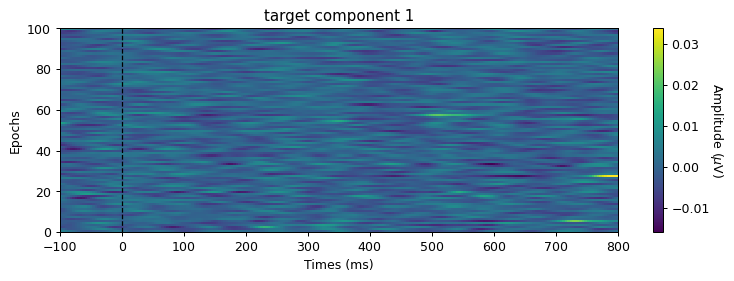

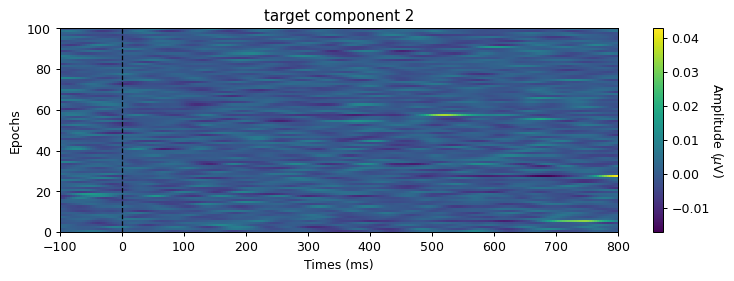

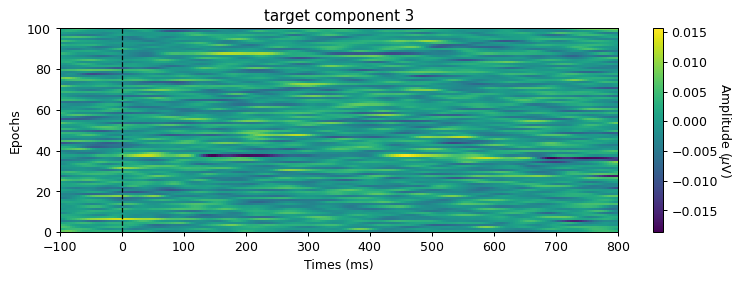

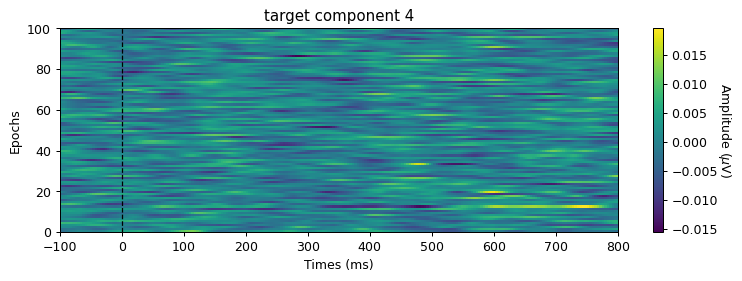

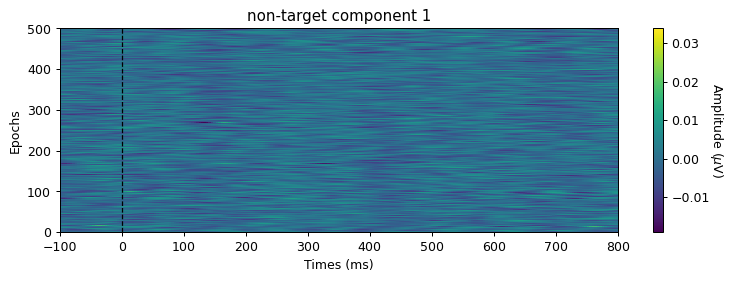

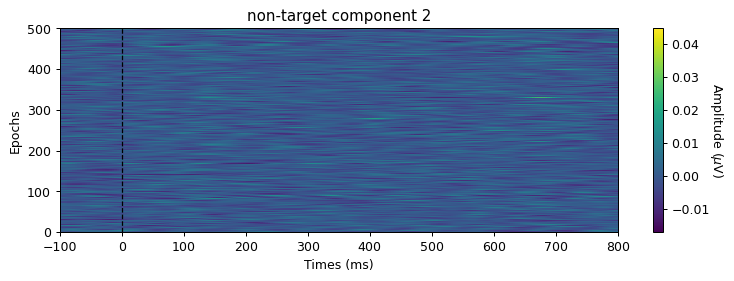

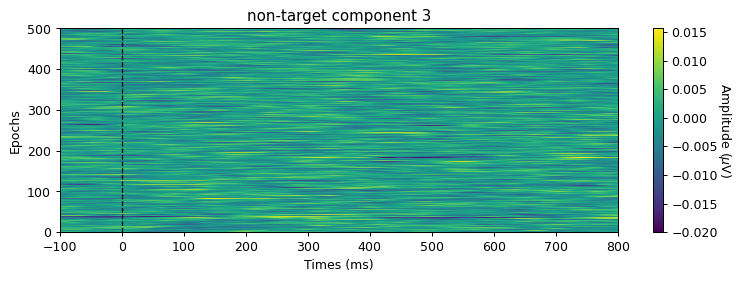

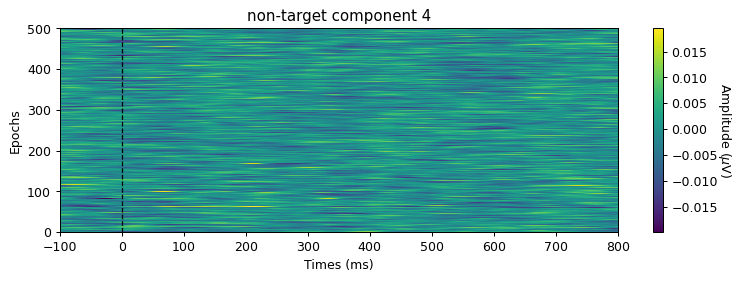

In [20]:
s_epochs = []
for event in r1_events:
    epoch = get_epoch(S_i, ts, event[0], PRE_STIM, POST_STIM, SAMPLE_RATE)
    s_epochs.append(epoch)
    
s_epochs = np.array(s_epochs)
target_s_epochs = s_epochs[r1_events[:,2] == 1]
# target_s_epochs.shape
for i in range(n_f):
    plot_epochs(target_s_epochs[:,:,i], title=f'target component {i+1}', tmin=-100, tmax=800)
    
nontarget_s_epochs = s_epochs[r1_events[:,2] == 0]
# target_s_epochs.shape
for i in range(n_f):
    plot_epochs(nontarget_s_epochs[:,:,i], title=f'non-target component {i+1}', tmin=-100, tmax=800)

In [21]:
shp = r1_y.shape
r1_bad_epochs_live = np.vstack((r1_bad_epochs//shp[1], r1_bad_epochs%shp[1])).T
r1_picks = np.ones(shp, bool)
r1_picks[r1_bad_epochs_live[:,0],r1_bad_epochs_live[:,1]] = 0

r1_windowed = window_and_combine_features(s_epochs, 7, (200, 600))
print(r1_windowed.shape)

epochs_by_target = r1_windowed.reshape(r1_y.shape + r1_windowed.shape[1:])
test_LDA_prediction(r1_target_ltr,
                    r1_stim_markers,
                    epochs_by_target,
                    r1_y,
                    r1_picks)

(600, 28)
training shape: (449, 28)
83.74% zeros
classifier score: 0.49557522123893805
-- Run: 0, Results --
row choice: 0, column choice: 3
D Q
training shape: (449, 28)
83.96% zeros
classifier score: 0.5752212389380531
-- Run: 1, Results --
row choice: 0, column choice: 3
D U
training shape: (454, 28)
83.92% zeros
classifier score: 0.4074074074074074
-- Run: 2, Results --
row choice: 1, column choice: 3
J I
training shape: (448, 28)
84.15% zeros
classifier score: 0.4649122807017544
-- Run: 3, Results --
row choice: 1, column choice: 3
J C
training shape: (448, 28)
84.15% zeros
classifier score: 0.5263157894736842
-- Run: 4, Results --
row choice: 0, column choice: 5
F K


In [35]:
s1_mask = np.ones(len(r1_epochs), np.bool)
s1_mask[r1_bad_epochs] = 0

s_epochs_clean = s_epochs[s1_mask]
r1_y_clean = r1_y.flatten()[s1_mask]
r1_events_clean = r1_events[s1_mask]

X_s, y_s = balance_zeros(s_epochs_clean, r1_y_clean)
print(X_s.shape)
X_windowed = window_and_combine_features(X_s, 7, (200, 600))
print(X_windowed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_s, test_size=0.20, random_state=35)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))

83.99% zeros
(185, 226, 4)
(185, 28)
Simple 20% test split accuracy: 0.4864864864864865


### again

(57083, 400)
(5, 5)
(5, 5)
(2, 5, 5)


(57083, 4)

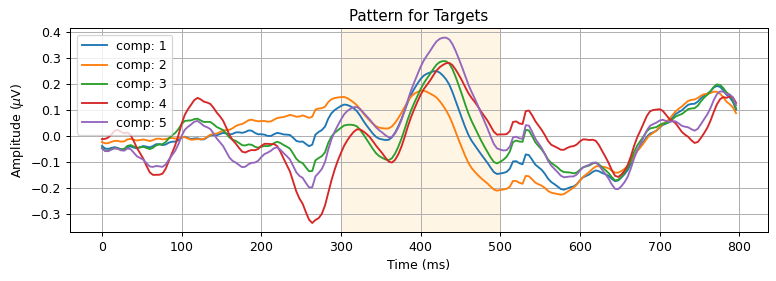

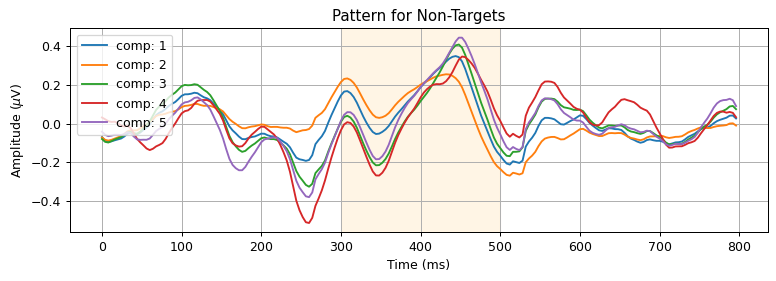

In [23]:
def reg_covariance(data, assume_centered = True):
    # data should be of shape (n_t, n_c)
    rank = np.linalg.matrix_rank(data)

    C = data.T @ data # watch the data shape, could be data.T * data

    # whitening ... PCA
    eig, eigvec = np.linalg.eigh(C)
    eigvec = eigvec.conj().T
    mask = np.ones(len(eig), bool)
    
    eig[:-rank] = 0.0
    mask[:-rank] = False
    
    eigvec = eigvec[mask]
    # data @ eigvec.T
#     print(eigvec.shape, data.shape)
    data_eig = eigvec.T @ data.T
    used = np.where(mask)[0]
    
    # compute 'empirical' covariance
    data_ = data_eig.copy()
    X = np.asarray(data_.T)
    
    if X.ndim == 1:
        X = np.reshape(X, (1,-1))

    if X.shape[0] == 1:
        warnings.warn("Only one sample available. "
                      "You may want to reshape your data array")

    if assume_centered:
        covariance = np.dot(X.T, X) / X.shape[0]
    else:
        covariance = np.cov(X.T, bias=1)
        
    # project back
    covariance = eigvec.T @ (covariance @ eigvec)
    # undo bias
    covariance *= data.shape[0]/(data.shape[0] - 1)
    
    return covariance

def build_toeplitz(data, data_ts, events, n_e, pre_stim_time = 0):
#     n_t = data.shape[0]
#     print(n_t, n_e)
#     n_e = ms_to_samples(erp_samples_size, SAMPLE_RATE)
    
    toeplitz = []
    stim_type = np.unique(events[:,2])
    n_minus = ms_to_samples(pre_stim_time, SAMPLE_RATE)
    for stim in stim_type:
        sel = events[:,2] == stim
        first_col = np.zeros((n_t))
        stim_pos_index = [get_closest_ts_index(data_ts, e[0]) for e in events[sel]]
        first_col[stim_pos_index] = 1
        first_row = np.zeros((n_e))
        toeplitz.append(linalg.toeplitz(first_col, first_row))
        
#     toeplitz = np.array(toeplitz)
    toeplitz = np.hstack(toeplitz)
    print(toeplitz.shape)
    return toeplitz

class xDAWN:
    def __init__(self, X, X_ts, events, erp_sample_size=800, sample_rate=250, use_reg_cov=False):
        self.X = X
        self.X_ts = X_ts
        self.events = events
        self.n_e = ms_to_samples(erp_sample_size, sample_rate)
        
        # toeplitz
        D = build_toeplitz(self.X, self.X_ts, self.events, self.n_e)

        # least square est
#         predictor = linalg.pinv(D.T @ D) @ D.T
#         P = predictor @ X
        P = linalg.inv(D.T @ D) @ D.T @ X
        

        classes = np.unique(events[:,2])
        P = (np.vsplit(P, len(classes)))
        D = np.hsplit(D, len(classes))
        
        
        # plot patterns
        x_for_plot = [(i*(1000/SAMPLE_RATE)) for i in range(P[0].shape[0])]
        comp_labels = [f'comp: {p+1}' for p in range(P[0].shape[1])]
        
        fig, ax = plot_time_series(
            x_for_plot,
            P[0],
            labels = comp_labels,
            xlabel='Time (ms)',
            ylabel=r'Amplitude ($\mu$V)',
            title=f'Pattern for Targets'
        )
        _ = ax.axvspan(300, 500, color='orange', alpha=0.1)
        
        fig, ax = plot_time_series(
            x_for_plot,
            P[1],
            labels = comp_labels,
            xlabel='Time (ms)',
            ylabel=r'Amplitude ($\mu$V)',
            title=f'Pattern for Non-Targets'
        )
        _ = ax.axvspan(300, 500, color='orange', alpha=0.1)


        # compute whitening covariance for the raw signal
        if use_reg_cov:
            sig_cov = reg_covariance(self.X)
        else:
            sig_cov = (self.X.T @ self.X) / len(self.X)

        
        filters = []
        patterns = []
        n_components = self.X.shape[1]

        for P_i, D_i in zip(P, D):

            # estimate cov matrix of prototype
            if use_reg_cov:
                evo = D_i @ P_i
                evo_cov = reg_covariance(evo)
            else:
                DP_i = P_i.T @ D_i.T @ D_i @ P_i
                evo_cov = DP_i / len(self.X)

            try:
                e_vals, e_vecs = linalg.eigh(evo_cov, sig_cov)
            except np.linalg.LinAlgError as exp:
                print('FAIL')

            e_vecs = e_vecs[:, np.argsort(e_vals)[::-1]]  # sort eigenvectors
            e_vecs /= np.apply_along_axis(np.linalg.norm, 0, e_vecs)
#             _patterns = np.linalg.pinv(e_vecs.T)
#             filters.append(e_vecs[:, :n_components].T)
            print(e_vecs[:, :n_components].shape)
            filters.append(e_vecs[:, :n_components])
#             patterns.append(_patterns[:, :n_components].T)


#         filters = np.concatenate(filters, axis=0)
#         patterns = np.concatenate(patterns, axis=0)
        
        self.filters = np.array(filters)
        
    def transform(self, X, n_f = 3):
        print(self.filters.shape)
        if self.filters.shape[1] != X.shape[1]:
            print('Channels and filters don\'t match. No transform performed.')
            return X

#         print('filters', self.filters.shape)
#         xfiltered = self.filters[:n_f] @ X.T
#         print('f', X.shape)
#         print('f', self.filters[0][:n_f].shape)
#         xfiltered = X @ self.filters[0][:n_f]
        xfiltered = X @ self.filters[0][:,:n_f]

        return xfiltered
    
    
r1_data = r1_eeg[:, [0,1,2,3,5]]
r1_data_ts = r1_eeg_ts

r1_xdawn = xDAWN(r1_data, r1_data_ts, r1_events, 800)
r1_filtered = r1_xdawn.transform(r1_data, 4)
r1_filtered.shape

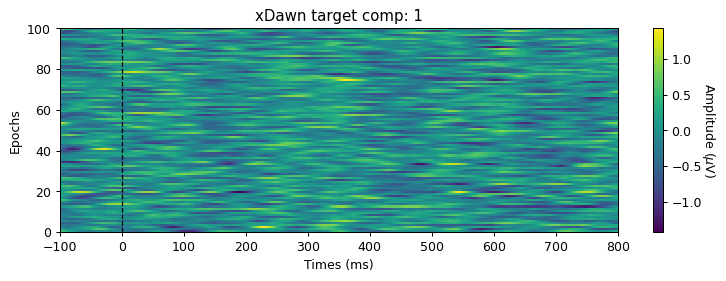

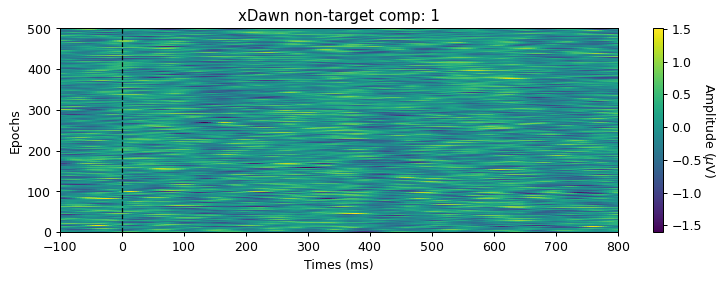

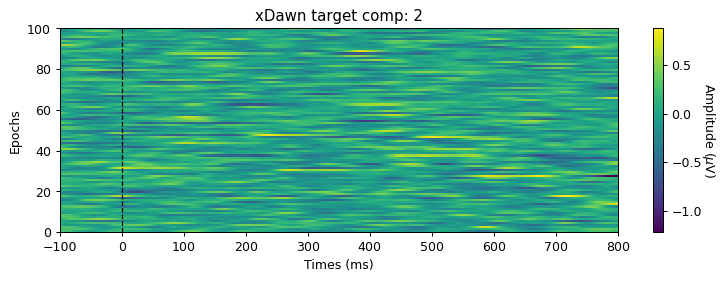

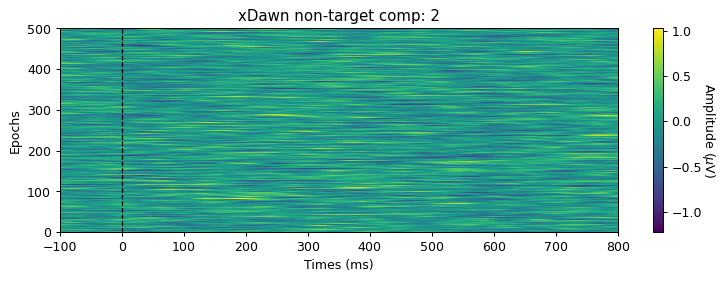

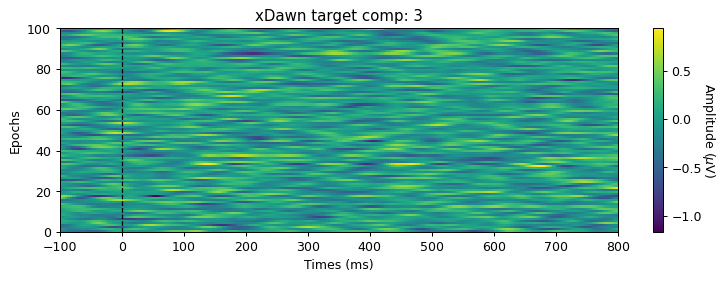

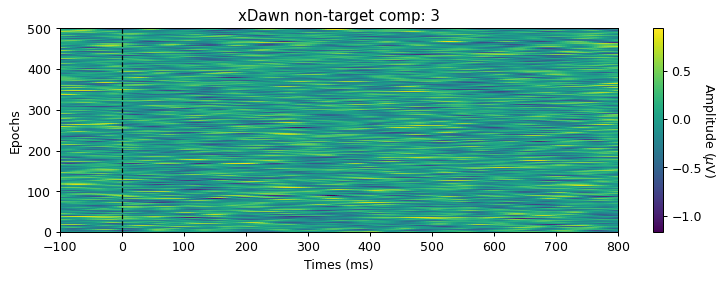

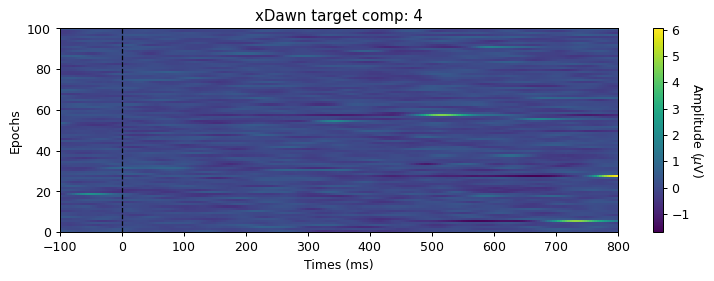

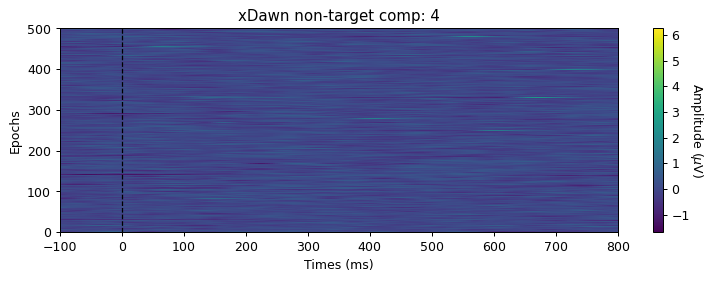

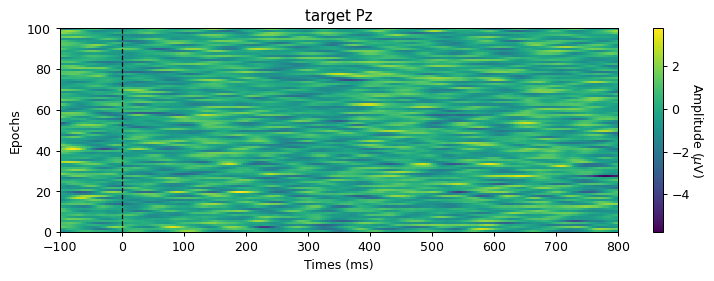

In [24]:
s_epochs = []
for event in r1_events:
    epoch = get_epoch(r1_filtered, r1_data_ts, event[0], PRE_STIM, POST_STIM, SAMPLE_RATE)
    s_epochs.append(epoch)
    
s_epochs = np.array(s_epochs)
target_s_epochs = s_epochs[r1_events[:,2] == 1]
nontarget_s_epochs = s_epochs[r1_events[:,2] == 0]

for i in range(r1_filtered.shape[1]):
    plot_epochs(target_s_epochs[:,:,i], title=f'xDawn target comp: {i+1}', tmin=-100, tmax=800)
    plot_epochs(nontarget_s_epochs[:,:,i], title=f'xDawn non-target comp: {i+1}', tmin=-100, tmax=800)
    
_ = plot_epochs(target_epochs[:,:,pz], title=f'target Pz', tmin=-100, tmax=800)    
    

In [25]:
s1_mask = np.ones(len(r1_epochs), np.bool)
s1_mask[r1_bad_epochs] = 0

s_epochs_clean = s_epochs[s1_mask]
r1_y_clean = r1_y.flatten()[s1_mask]
r1_events_clean = r1_events[s1_mask]

X_s, y_s = balance_zeros(s_epochs_clean, r1_y_clean)
print(X_s.shape)
X_windowed = window_and_combine_features(X_s, 7, (200, 600))
print(X_windowed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_s, test_size=0.20, random_state=40)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))

83.99% zeros
(185, 226, 4)
(185, 28)
Simple 20% test split accuracy: 0.5945945945945946


(57083, 400)
(5, 5)
(5, 5)
(2, 5, 5)
83.99% zeros
(185, 226, 4)
(185, 28)
Simple 20% test split accuracy: 0.5405405405405406


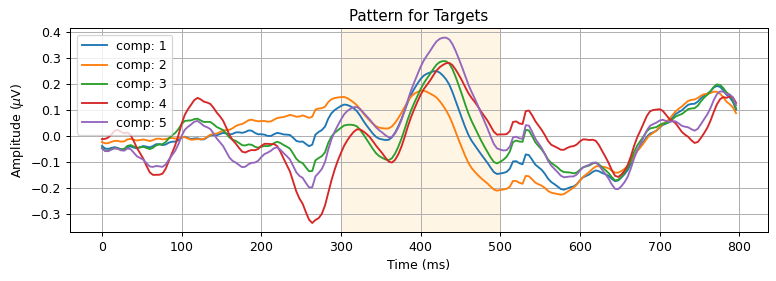

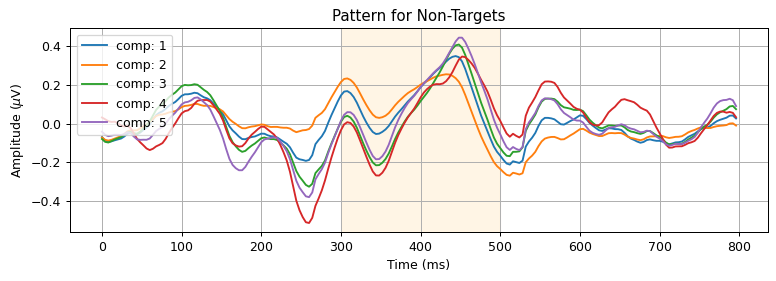

In [39]:
r1_xdawn = xDAWN(r1_data, r1_data_ts, r1_events, 800, use_reg_cov=True)
r1_filtered = r1_xdawn.transform(r1_data, 4)
r1_filtered.shape


s_epochs = []
for event in r1_events:
    epoch = get_epoch(r1_filtered, r1_data_ts, event[0], PRE_STIM, POST_STIM, SAMPLE_RATE)
    s_epochs.append(epoch)
    
s_epochs = np.array(s_epochs)
target_s_epochs = s_epochs[r1_events[:,2] == 1]
nontarget_s_epochs = s_epochs[r1_events[:,2] == 0]

s1_mask = np.ones(len(r1_epochs), np.bool)
s1_mask[r1_bad_epochs] = 0

s_epochs_clean = s_epochs[s1_mask]
r1_y_clean = r1_y.flatten()[s1_mask]
r1_events_clean = r1_events[s1_mask]

X_s, y_s = balance_zeros(s_epochs_clean, r1_y_clean)
print(X_s.shape)
X_windowed = window_and_combine_features(X_s, 7, (200, 600))
print(X_windowed.shape)

X_train, X_test, y_train, y_test = train_test_split(X_windowed, y_s, test_size=0.20, random_state=40)
LDA_clf = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto').fit(X_train, y_train)
print('Simple 20% test split accuracy:', LDA_clf.score(X_test, y_test))